<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Subreddit Classifier - Tea or Coffee?
By Amira (DSI-28 SG)

---
# Problem Statement

We are a team of data scientists working for Coffea Vibes, a beverage company. The company is venturing into e-commerce and will be launching its own website/application selling coffee and tea products to consumers. We have been tasked to build a classification model that can accurately distinguish between coffee and tea in textual data.

Our classification model will contribute to the following use cases:

1. Our web development team can optimise the recommender systems so as to accurately suggest related products and advertisements to our potential consumers who might have varying preferences for coffee or tea.
2. Our business insights team can leverage on the classification model to correctly distinguish customer feedback on coffee and tea (e.g. through emails) and comments made on the company's social media pages, to aid better understanding of customer's feedback and take appropriate actions quickly, if necessary.

We evaluated the models based on the following criteria:

1. Accuracy scores (the higher, the better)
2. Delta between train and test scores (the smaller, the better)
3. Clear distinction of important features i.e. words to distinguish coffee and tea

---
# Structure

To organise my work better, I have organised this project into two notebooks: 

* Notebook 1 : Data Acquisition
* Notebook 2: Data Cleaning & Exploratory Data Analysis
* Notebook 3: Modelling & Model Evaluation

<span style='color:red'>**This is Notebook 3.**</span>

---
## Part 3: Preprocessing & Modelling

In [1]:
# import required libraries/packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk

# importing NLP packages
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

# importing modeling packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report,accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
# load csv file
posts = pd.read_csv('./data/submissions.csv')

In [3]:
posts['subreddit'].value_counts()

Coffee    1472
tea       1370
Name: subreddit, dtype: int64

<AxesSubplot:xlabel='subreddit', ylabel='count'>

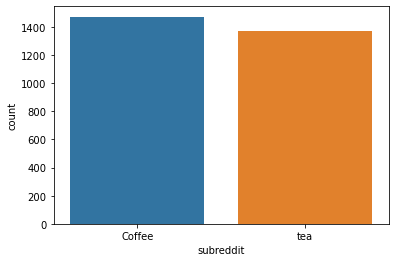

In [4]:
sns.countplot(x='subreddit',data=posts)

### Model Prep: Dummify Labels

In [5]:
# Dummify 'subreddit' column for classification
# Label 1 for coffee, 0 for tea

posts['subreddit'] = posts['subreddit'].apply(lambda x: 0 if x == 'Coffee' else 1)

### Model Prep: Custom Stopwords

**Note:** Based on the EDA performed earlier, I have identified several words that are not in the ntlk.stopwords corpus but are common in both coffee and tea dfs. Since they are common words between the two categories, they will not be useful in correctly classification a post into either category. Therefore, I will drop these words from the text data.

In [6]:
my_stopwords = ['coffee','tea','im','like','ive','try','water','taste','drink','know','want','cup','taste','look','question','use','dont']

# add words: ,'get''hey','make','thanks','advance','good','time'

In [7]:
def custom_stopwords(text):
    tokens = re.split('\W+', text)
    text = " ".join([w for w in tokens if w not in my_stopwords])    
    return text

In [8]:
# apply removal of custom stopwords to clean_full_text (previously cleaned/lemmatized in notebook 2)
posts['clean_full_text'] = posts['clean_full_text'].apply(lambda x: custom_stopwords(str(x)))

### Model Prep: Train/test split

In [9]:
# our target is the subreddit labels: 0 for coffee, 1 for tea
X = posts['clean_full_text']
y = posts['subreddit']

In [10]:
# stratify to keep same balance of y in the test and train data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)
print(X_train.shape)
print(y_train.shape)

(2131,)
(2131,)


## Summary of Model Performance

The **CountVectorizer - Multinomial Naive Bayes model** is the best performing model, based on the test score and minimal overfitting:

| Method | Train Score | Test Score (Accuracy) |Delta|Evaluation|
| :-: | :-: | :-: | :-:|:-:|
| Baseline | - | 0.52 | -|-|
| CountVect + Multi NB | 0.93 | 0.88| 0.05 | 1st |
| TF-IDF + Log Regression | 0.96 | 0.87 | 0.09 |2nd |
|TF-IDF + Multi NB | 0.95 | 0.86 | 0.09 | 3rd |
| CountVect + Log Regression | 0.99 | 0.85 | 0.14 |4th |
| CountVect + Random Forest | 1.0 | 0.84 | 0.16 |5th |
| TF-IDF + Random Forest | 1.0 | 0.83 | 0.17 | 6th |

**We will not use the gridsearchCV best_score as the evaluating criteria, since we are not working with truly unseen test data.

### Baseline Accuracy

**Note:** There is slightly more posts from coffee than tea subreddits in this dataset. Our base model will tend to predict coffee, but it will only be accurate around ~51% of the time. We build complex models to perform better than this. 

In [11]:
# Label 1 for coffee, 0 for tea
y_test.value_counts(normalize=True)

0    0.517581
1    0.482419
Name: subreddit, dtype: float64

### Model 1: CountVectorizer & Multinomial Naive Bayes

In [12]:
# set pipeline and parameters 
pipe1 = Pipeline([('cvec',CountVectorizer()),('nb', MultinomialNB())])

# gridsearchcv done on several parameters, and found the optimal values as follows:
params1 = {
    'cvec__max_features': [5_000], #[3_000,5_000, 7_000]
    'cvec__min_df': [2], #[2, 3]
    'cvec__max_df': [0.9], #[0.9, 0.95]
    'cvec__ngram_range': [(1,1)], #[(1,1),(1,2)]
    'nb__alpha' : [0.8]  #(0.5,1.5,.1)
}

In [13]:
# set gridsearch 
gs1 = GridSearchCV(pipe1, 
                  param_grid=params1,
                  cv=5,
                  n_jobs=-1) 

In [14]:
# fit train set to gridsearch, pipe and params
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 1)],
                         'nb__alpha': [0.8]})

In [15]:
# derive the best score and best parameters
print(f'Mean cross-val score of the best_estimator for model 1: {gs1.best_score_}.') 
print(f'Best parameters for model 1: {gs1.best_params_}.')

Mean cross-val score of the best_estimator for model 1: 0.877535156292949.
Best parameters for model 1: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'nb__alpha': 0.8}.


In [16]:
# Score model on train and test sets
print(f'Train score: {gs1.score(X_train, y_train)}')
print(f'Test score: {gs1.score(X_test, y_test)}')

Train score: 0.9296105114969498
Test score: 0.8790436005625879


In [17]:
# get predictions
preds1 = gs1.predict(X_test)

In [18]:
# save confusion matrix values
cm1 = confusion_matrix(y_test, preds1)
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, preds1).ravel()

In [19]:
# calculate classification metrics 
score1 = gs1.score(X_test, y_test) # accuracy score
prec1 = precision_score(y_test, preds1) # precision score
rec1 = recall_score(y_test, preds1) # recall/sensitivity score
spec1 = tn1 / (tn1 + fp1) # specificity score

In [20]:
# Create modified labels for confusion matrix
modified_cm1 = []
for index,value in enumerate(cm1):
    if index == 0:
        modified_cm1.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm1.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

Text(0.5, 1.05, 'Confusion Matrix for Model 1: CountVectorizer x Multinomial Naive Bayes')

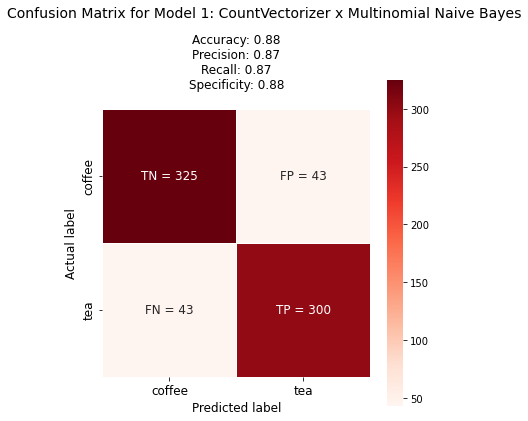

In [21]:
# plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm1, annot=np.array(modified_cm1),
            fmt="",
            annot_kws={"size": 12},
            linewidths=.5,
            square = True,
            cmap = 'Reds',
            xticklabels = ['coffee', 'tea'],
            yticklabels = ['coffee', 'tea'],
            );

plt.ylabel('Actual label', fontsize = 12);
plt.xlabel('Predicted label', fontsize = 12);
plt.title('Accuracy: {:.2f}'.format(score1)+'\n'
          +'Precision: {:.2f}'.format(prec1)+'\n'
          +'Recall: {:.2f}'.format(rec1)+'\n'
          + 'Specificity: {:.2f}'.format(spec1)+'\n', size = 12);
plt.tick_params(labelsize= 12)
plt.suptitle('Confusion Matrix for Model 1: CountVectorizer x Multinomial Naive Bayes', y = 1.05,fontsize=14)

### Model 1: Feature Importance

In [22]:
# pass best estimator model into a variable
gs1_model = gs1.best_estimator_

In [23]:
# set variables to access the model steps by name 
transformer1 = gs1_model.named_steps['cvec']
estimator1 = gs1_model.named_steps['nb']

In [24]:
# create a dataframe to store feature name against difference in the log probabilities between the two classes
df1 = pd.DataFrame()
df1['feature'] = transformer1.get_feature_names()
df1['log_prob_diff'] = estimator1.feature_log_prob_[1,:] - estimator1.feature_log_prob_[0,:]

In [25]:
# print the top 10 features for tea
df1.sort_values(by=['log_prob_diff'],ascending=False).head(10)

,feature,log_prob_diff
2168,oolong,5.443423
2467,puerh,4.612846
2761,sencha,4.519320
1648,jasmine,4.442947
515,china,4.442947
1900,matcha,4.366620
1456,herbal,4.360255
3146,teapot,4.273592
942,earl,4.270104
1373,grey,4.238152


In [26]:
# print the top 10 features for coffee
df1.sort_values(by=['log_prob_diff'],ascending=True).head(10)

,feature,log_prob_diff
1853,machine,-5.626614
1375,grinder,-5.529501
1374,grind,-5.368343
390,burr,-4.429786
1022,espresso,-4.314601
55,aeropress,-4.297200
257,bean,-4.243103
2001,moka,-4.155262
2655,roaster,-4.027626
1380,ground,-3.721065


### Model 2: TF-IDF Vectorizer & Multinomial Naive Bayes

In [27]:
# set pipeline and parameters 
pipe2 = Pipeline([
                ('tf', TfidfVectorizer()),
                ('nb', MultinomialNB())
])

# gridsearchcv done on several parameters, and found the optimal values as follows:
params2 = {
                'tf__max_features' : [3_000], #[3_000,5_000, 7_000]
                'tf__ngram_range' : [(1,2)], #[(1,1), (1,2)]
                'nb__alpha' : [0.5] #np.arange(0.5,1.5,.1)
}

In [28]:
# set gridsearch
gs2 = GridSearchCV(pipe2, param_grid = params2, cv = 5,n_jobs=-1)

In [29]:
# fit train set to gridsearch, pipe and params
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.5], 'tf__max_features': [3000],
                         'tf__ngram_range': [(1, 2)]})

In [30]:
# derive the best score and best parameters
print(f'Mean cross-val score of the best_estimator for model 2: {gs2.best_score_}.') 
print(f'Best parameters for model 2: {gs2.best_params_}.')

Mean cross-val score of the best_estimator for model 2: 0.8751921364251081.
Best parameters for model 2: {'nb__alpha': 0.5, 'tf__max_features': 3000, 'tf__ngram_range': (1, 2)}.


In [31]:
# Score model on train and test sets.
print(f'Train score: {gs2.score(X_train, y_train)}')
print(f'Test score: {gs2.score(X_test, y_test)}')

Train score: 0.9507273580478649
Test score: 0.8565400843881856


In [32]:
# get predictions
preds2 = gs2.predict(X_test)

In [33]:
# save confusion matrix values
cm2 = confusion_matrix(y_test, preds2)
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds2).ravel()

In [34]:
# calculate classification metrics 
score2 = gs2.score(X_test, y_test) # accuracy score
prec2 = precision_score(y_test, preds2) # precision score
rec2 = recall_score(y_test, preds2) # recall/sensitivity score
spec2 = tn2 / (tn2 + fp2) # specificity score

In [35]:
# Create modified labels for confusion matrix
modified_cm2 = []
for index,value in enumerate(cm2):
    if index == 0:
        modified_cm2.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm2.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

Text(0.5, 1.05, 'Confusion Matrix for Model 2: TF-IDF Vectorizer x Multinomial Naive Bayes')

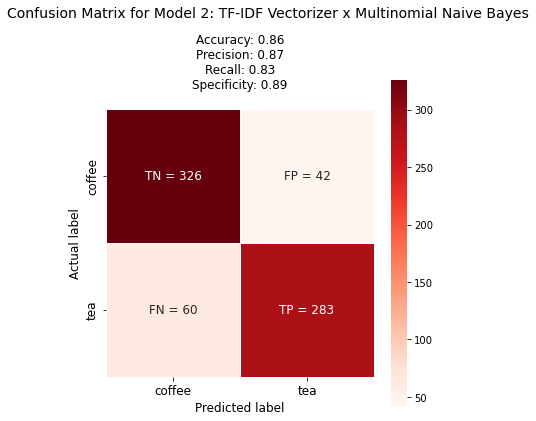

In [36]:
# plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm2, annot=np.array(modified_cm2),
            fmt="",
            annot_kws={"size": 12},
            linewidths=.5,
            square = True,
            cmap = 'Reds',
            xticklabels = ['coffee', 'tea'],
            yticklabels = ['coffee', 'tea'],
            );

plt.ylabel('Actual label', fontsize = 12);
plt.xlabel('Predicted label', fontsize = 12);
plt.title('Accuracy: {:.2f}'.format(score2)+'\n'
          +'Precision: {:.2f}'.format(prec2)+'\n'
          +'Recall: {:.2f}'.format(rec2)+'\n'
          + 'Specificity: {:.2f}'.format(spec2)+'\n', size = 12);
plt.tick_params(labelsize= 12)
plt.suptitle('Confusion Matrix for Model 2: TF-IDF Vectorizer x Multinomial Naive Bayes', y = 1.05,fontsize=14)

### Model 2: Feature Importance

In [37]:
# pass best estimator model into a variable
gs2_model = gs2.best_estimator_

In [38]:
# set variables to access the model steps by name 
transformer2 = gs2_model.named_steps['tf']
estimator2 = gs2_model.named_steps['nb']

In [39]:
# create a dataframe to store feature names against difference in the log probabilities between the two classes
df2 = pd.DataFrame()
df2['feature'] = transformer2.get_feature_names()
df2['log_prob_diff'] = estimator2.feature_log_prob_[1,:] - estimator2.feature_log_prob_[0,:]

In [40]:
# print the top 10 features for tea
df2.sort_values(by=['log_prob_diff'],ascending=False).head(10)

,feature,log_prob_diff
1851,oolong,3.962467
2618,teapot,3.497795
1141,green,3.313198
1545,loose leaf,3.295272
1474,leaf,3.236636
2313,sencha,3.230257
2064,puerh,3.199478
1544,loose,3.116338
425,chamomile,2.938115
1181,gyokuro,2.914655


In [41]:
# print the top 10 features for coffee
df2.sort_values(by=['log_prob_diff'],ascending=True).head(10)

,feature,log_prob_diff
1565,machine,-3.949948
1153,grinder,-3.820902
806,espresso,-3.739900
1144,grind,-3.658280
217,bean,-3.507042
350,burr,-3.041425
1167,ground,-2.974716
47,aeropress,-2.929062
811,espresso machine,-2.864322
1708,moka,-2.824374


### Model 3: TF-IDF Vectorizer & Logistic Regression

In [42]:
# set pipeline and parameters 
pipe3 = Pipeline([
                ('tf', TfidfVectorizer()),
                ('lr', LogisticRegression(max_iter=5_000))
])

# gridsearchcv done on several parameters, and found the optimal values as follows:
params3 = {
                'tf__max_features' : [5_000], #[3_000,5_000, 7_000]
                'tf__ngram_range' : [(1,2)], #[(1,1), (1,2)]
                'lr__solver' : ['liblinear'], #['liblinear','lbfgs']
                'lr__penalty' : ['l2'] #['l1','l2']
}

In [43]:
# set gridsearch
gs3 = GridSearchCV(pipe3, param_grid = params3, cv = 5,n_jobs=-1)

In [44]:
# fit train set to grisearch, pipe, parameters
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'lr__penalty': ['l2'], 'lr__solver': ['liblinear'],
                         'tf__max_features': [5000],
                         'tf__ngram_range': [(1, 2)]})

In [45]:
# derive the best score and best parameters
print(f'Mean cross-val score of the best_estimator for model 3: {gs3.best_score_}.') 
print(f'Best parameters for model 3: {gs3.best_params_}.')

Mean cross-val score of the best_estimator for model 3: 0.8789436069971742.
Best parameters for model 3: {'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tf__max_features': 5000, 'tf__ngram_range': (1, 2)}.


In [46]:
# score model on train & test sets
print(f'Train score: {gs3.score(X_train, y_train)}')
print(f'Test score: {gs3.score(X_test, y_test)}')

Train score: 0.9648052557484749
Test score: 0.8663853727144867


In [47]:
# get predictions
preds3 = gs3.predict(X_test)

In [48]:
# save confusion matrix values
cm3 = confusion_matrix(y_test, preds3)
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, preds3).ravel()

In [49]:
# calculate classification metrics 
score3 = gs3.score(X_test, y_test) # accuracy score
prec3 = precision_score(y_test, preds3) # precision score
rec3 = recall_score(y_test, preds3) # recall/sensitivity score
spec3 = tn3 / (tn3 + fp3) # specificity score

In [50]:
# create modified labels for confusion matrix
modified_cm3 = []
for index,value in enumerate(cm3):
    if index == 0:
        modified_cm3.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm3.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

Text(0.5, 1.05, 'Confusion Matrix for Model 3: TD-IDF Vectorizer x Logistic Regression')

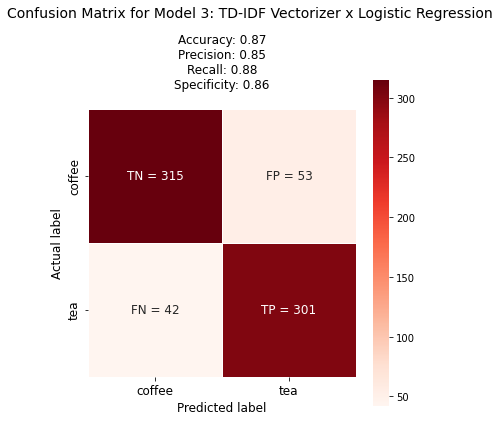

In [51]:
# plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm3, annot=np.array(modified_cm3),
            fmt="",
            annot_kws={"size": 12},
            linewidths=.5,
            square = True,
            cmap = 'Reds',
            xticklabels = ['coffee', 'tea'],
            yticklabels = ['coffee', 'tea'],
            );

plt.ylabel('Actual label', fontsize = 12);
plt.xlabel('Predicted label', fontsize = 12);
plt.title('Accuracy: {:.2f}'.format(score3)+'\n'
          +'Precision: {:.2f}'.format(prec3)+'\n'
          +'Recall: {:.2f}'.format(rec3)+'\n'
          + 'Specificity: {:.2f}'.format(spec3)+'\n', size = 12);
plt.tick_params(labelsize= 12)
plt.suptitle('Confusion Matrix for Model 3: TD-IDF Vectorizer x Logistic Regression', y = 1.05,fontsize=14)

### Model 3: Feature Importance

In [52]:
# pass best estimator model into a variable
gs3_model = gs3.best_estimator_

In [53]:
# set variables to access the model steps by name 
transformer3 = gs3_model.named_steps['tf']
estimator3 = gs3_model.named_steps['lr']

In [54]:
# create a dataframe to store feature names against the exponential of their coefficients
df3 = pd.DataFrame()
df3['feature'] = transformer3.get_feature_names()
df3['coefficient'] = estimator3.coef_.T
df3['exp_coef'] = np.exp(df3['coefficient'])

In [55]:
# print the top 10 features for tea
df3.sort_values(by=['coefficient'],ascending=False).head(10)

,feature,coefficient,exp_coef
1939,green,3.193086,24.363495
2495,leaf,3.068149,21.502070
3160,oolong,2.611332,13.617180
4392,teapot,2.416570,11.207352
2764,matcha,2.205120,9.071340
3902,sencha,1.748505,5.746006
2593,loose,1.637350,5.141528
4214,steep,1.567721,4.795707
4836,white,1.513108,4.540821
2408,kettle,1.449290,4.260088


In [56]:
# print the top 10 features for coffee
df3.sort_values(by=['coefficient'],ascending=True).head(10)

,feature,coefficient,exp_coef
336,bean,-4.039459,0.017607
2642,machine,-3.858870,0.021092
1338,espresso,-3.653906,0.025890
1969,grinder,-3.220058,0.039953
1950,grind,-2.751581,0.063827
3750,roast,-2.354577,0.094934
1995,ground,-2.184936,0.112485
2727,maker,-2.166135,0.114620
3765,roaster,-1.993205,0.136258
601,burr,-1.891399,0.150861


### Model 4: Count Vectorizer & Logistic Regression

In [57]:
# set pipeline and parameters 
pipe4 = Pipeline([
    ('cvec',CountVectorizer()),
    ('lr', LogisticRegression(max_iter=3_000))
])

# gridsearchcv done on several parameters, and found the optimal values as follows:
params4 = {
    'cvec__max_features': [3_000], #[3_000,5_000, 7_000]
    'cvec__min_df': [2], #[2, 3]
    'cvec__max_df': [0.9], #[0.9, 0.95]
    'cvec__ngram_range': [(1,1)], #[(1,1), (1,2)]
    'lr__solver' : ['liblinear'], #['liblinear','lbfgs']
    'lr__penalty' : ['l2'] #['l1','l2']   
}

In [58]:
# set gridsearch
gs4 = GridSearchCV(pipe4, 
                  param_grid=params4,
                  cv=5,
                  n_jobs=-1) 

In [59]:
# fit train set to grisearch, pipe, parameters
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [3000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 1)],
                         'lr__penalty': ['l2'], 'lr__solver': ['liblinear']})

In [60]:
# derive the best score and best parameters
print(f'Mean cross-val score of the best_estimator for model 4: {gs4.best_score_}.') 
print(f'Best parameters for model 4: {gs4.best_params_}.')

Mean cross-val score of the best_estimator for model 4: 0.867201020329628.
Best parameters for model 4: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}.


In [61]:
# Score model on train and test sets
print(f'Train score: {gs4.score(X_train, y_train)}')
print(f'Test score: {gs4.score(X_test, y_test)}')

Train score: 0.987329892069451
Test score: 0.8523206751054853


In [62]:
# get predictions
preds4 = gs4.predict(X_test)

In [63]:
# save confusion matrix values
cm4 = confusion_matrix(y_test, preds4)
tn4, fp4, fn4, tp4 = confusion_matrix(y_test, preds4).ravel()

In [64]:
# calculate classification metrics
score4 = gs4.score(X_test, y_test) # accuracy score
prec4 = precision_score(y_test, preds4) # precision score
rec4 = recall_score(y_test, preds4) # recall/sensitivity score
spec4 = tn4 / (tn4 + fp4) # specificity score

In [65]:
# create modified labels for confusion matrix
modified_cm4 = []
for index,value in enumerate(cm4):
    if index == 0:
        modified_cm4.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm4.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

Text(0.5, 1.05, 'Confusion Matrix for Model 4: Count Vectorizer x Logistic Regression')

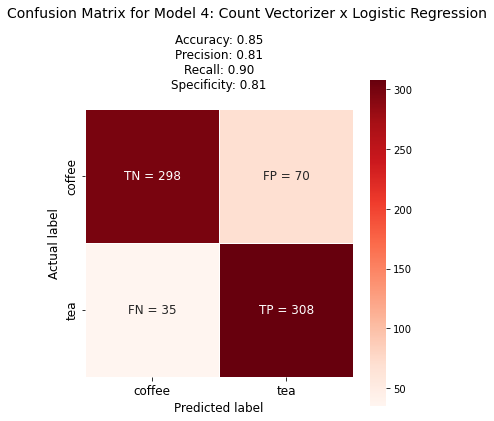

In [66]:
# plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm4, annot=np.array(modified_cm4),
            fmt="",
            annot_kws={"size": 12},
            linewidths=.5,
            square = True,
            cmap = 'Reds',
            xticklabels = ['coffee', 'tea'],
            yticklabels = ['coffee', 'tea'],
            );

plt.ylabel('Actual label', fontsize = 12);
plt.xlabel('Predicted label', fontsize = 12);
plt.title('Accuracy: {:.2f}'.format(score4)+'\n'
          +'Precision: {:.2f}'.format(prec4)+'\n'
          +'Recall: {:.2f}'.format(rec4)+'\n'
          + 'Specificity: {:.2f}'.format(spec4)+'\n', size = 12);
plt.tick_params(labelsize= 12)
plt.suptitle('Confusion Matrix for Model 4: Count Vectorizer x Logistic Regression', y = 1.05,fontsize=14)

### Model 4: Feature Importance

In [67]:
# pass best estimator model into a variable
gs4_model = gs4.best_estimator_

In [68]:
# set variables to access the model steps by name 
transformer4 = gs4_model.named_steps['cvec']
estimator4 = gs4_model.named_steps['lr']

In [69]:
# create a dataframe to store feature name against the exponential of their coefficients
df4 = pd.DataFrame()
df4['feature'] = transformer4.get_feature_names()
df4['coefficient'] = estimator4.coef_.T
df4['exp_coef'] = np.exp(df4['coefficient'])

In [70]:
# top 10 features for tea
df4.sort_values(by=['coefficient'],ascending=False).head(10)

,feature,coefficient,exp_coef
1147,green,1.996876,7.366009
1446,leaf,1.668523,5.304329
1757,oolong,1.496690,4.466878
1553,matcha,1.455922,4.288435
2576,teapot,1.445799,4.245242
2218,sencha,1.247185,3.480531
1500,loose,1.134766,3.110445
144,assam,1.047300,2.849945
379,cha,1.002057,2.723880
380,chai,1.001071,2.721195


In [71]:
# top 10 features for coffee
df4.sort_values(by=['coefficient'],ascending=True).head(10)

,feature,coefficient,exp_coef
854,espresso,-2.286403,0.101631
1521,machine,-2.272105,0.103095
201,bean,-2.158183,0.115535
1151,grinder,-1.778191,0.168943
1532,maker,-1.758553,0.172294
2130,roaster,-1.743619,0.174886
1154,ground,-1.675497,0.187215
2364,specialty,-1.516416,0.219497
1630,moka,-1.401287,0.246280
2406,starbucks,-1.256033,0.284782


### Model 5: Count Vectorizer & Random Forest Classifier

In [72]:
# set pipeline and parameters
pipe5 = Pipeline([
    ('cvec',CountVectorizer()),
    ('rf', RandomForestClassifier())
])

# gridsearchcv done on several parameters, and found the optimal values as follows:
params5 = {
    'cvec__max_features': [3_000], #[3_000,5_000, 7_000]
    'cvec__min_df': [3], #[2, 3]
    'cvec__max_df': [0.95], #[0.9, 0.95]
    'cvec__ngram_range': [(1,1)], #[(1,1), (1,2)]
    'rf__n_estimators': [150], #[100, 150]
    'rf__max_depth': [None]  #[None, 1, 2, 3]
}

In [73]:
# set gridsearch 
gs5 = GridSearchCV(pipe5,
                  param_grid=params5,
                  cv=5,
                  n_jobs=-1)

In [74]:
# fit train set 
gs5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.95], 'cvec__max_features': [3000],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 1)],
                         'rf__max_depth': [None], 'rf__n_estimators': [150]})

In [75]:
# derive best score and best parameters
print(f'Mean cross-val score of the best_estimator for model 5: {gs5.best_score_}.') 
print(f'Best parameters for model 5: {gs5.best_params_}.')

Mean cross-val score of the best_estimator for model 5: 0.8409154379830899.
Best parameters for model 5: {'cvec__max_df': 0.95, 'cvec__max_features': 3000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'rf__max_depth': None, 'rf__n_estimators': 150}.


In [76]:
# score model on train and test sets
print(f'Train score: {gs5.score(X_train, y_train)}')
print(f'Test score: {gs5.score(X_test, y_test)}')

Train score: 0.999530736743313
Test score: 0.8312236286919831


In [77]:
# get predictions
preds5 = gs5.predict(X_test)

In [78]:
# save confusion matrix values
cm5 = confusion_matrix(y_test, preds5)
tn5, fp5, fn5, tp5 = confusion_matrix(y_test, preds5).ravel()

In [79]:
# calculate classification metrics
score5 = gs5.score(X_test, y_test) # accuracy score
prec5 = precision_score(y_test, preds5) # precision score
rec5 = recall_score(y_test, preds5) # recall/sensitivity score
spec5 = tn5 / (tn5 + fp5) # specificity score

In [80]:
# create modified labels for confusion matrix
modified_cm5 = []
for index,value in enumerate(cm5):
    if index == 0:
        modified_cm5.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm5.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

Text(0.5, 1.05, 'Confusion Matrix for Model 5: Count Vectorizer x Random Forest')

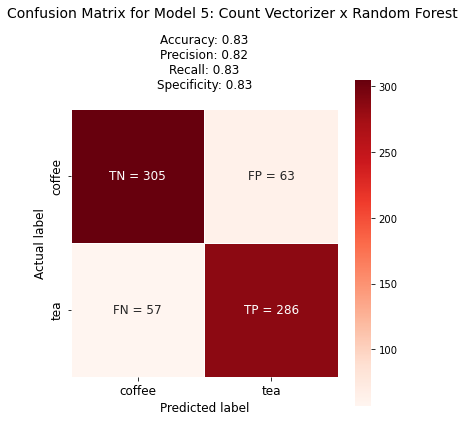

In [81]:
# plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm5, annot=np.array(modified_cm5),
            fmt="",
            annot_kws={"size": 12},
            linewidths=.5,
            square = True,
            cmap = 'Reds',
            xticklabels = ['coffee', 'tea'],
            yticklabels = ['coffee', 'tea'],
            );

plt.ylabel('Actual label', fontsize = 12);
plt.xlabel('Predicted label', fontsize = 12);
plt.title('Accuracy: {:.2f}'.format(score5)+'\n'
          +'Precision: {:.2f}'.format(prec5)+'\n'
          +'Recall: {:.2f}'.format(rec5)+'\n'
          + 'Specificity: {:.2f}'.format(spec5)+'\n', size = 12);
plt.tick_params(labelsize= 12)
plt.suptitle('Confusion Matrix for Model 5: Count Vectorizer x Random Forest', y = 1.05,fontsize=14)

### Model 5: Feature Importance

In [82]:
# pass best estimator model into a variable
gs5_model = gs5.best_estimator_

In [83]:
# set variables to access the model steps by name 
transformer5 = gs5_model.named_steps['cvec']
estimator5 = gs5_model.named_steps['rf']

In [84]:
# create a dataframe to store feature name against the exponential of their coefficients
df5 = pd.DataFrame()
df5['feature'] = transformer5.get_feature_names()
df5['importance'] = estimator5.feature_importances_

In [85]:
# top 10 features
df5.sort_values(by=['importance'],ascending=False).head(20)

,feature,importance
1327,machine,0.031474
189,bean,0.027452
727,espresso,0.027061
985,grinder,0.022993
984,grind,0.019340
981,green,0.015648
1258,leaf,0.014188
988,ground,0.012073
1891,roast,0.011271
294,burr,0.009008


### Model 6: TF-IDF Vectorizer & Random Forest Classifier

In [86]:
# set pipeline and parameters
pipe6 = Pipeline([
    ('tf',TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# gridsearchcv done on several parameters, and found the optimal values as follows:
params6 = {
    'tf__max_features' : [3_000],  #[3_000,5_000, 7_000]
    'tf__ngram_range' : [(1,1)], #[(1,1), (1,2)]
    'rf__n_estimators': [100], #[100, 150]
    'rf__max_depth': [None] #[None, 1, 2, 3]
}

In [87]:
# set gridsearch
gs6 = GridSearchCV(pipe6,
                  param_grid=params6,
                  cv=5,
                  n_jobs=-1)

In [88]:
# fit on train set
gs6.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None], 'rf__n_estimators': [100],
                         'tf__max_features': [3000],
                         'tf__ngram_range': [(1, 1)]})

In [89]:
# derive the best score and best parameteres
print(f'Mean cross-val score of the best_estimator for model 5: {gs6.best_score_}.') 
print(f'Best parameters for model 5: {gs6.best_params_}.')

Mean cross-val score of the best_estimator for model 5: 0.8343558619476422.
Best parameters for model 5: {'rf__max_depth': None, 'rf__n_estimators': 100, 'tf__max_features': 3000, 'tf__ngram_range': (1, 1)}.


In [90]:
# Score model on train and test sets
print(f'Train score: {gs6.score(X_train, y_train)}')
print(f'Test score: {gs6.score(X_test, y_test)}')

Train score: 1.0
Test score: 0.8270042194092827


In [91]:
# get predictions
preds6 = gs6.predict(X_test)

In [92]:
# save confusion matrix values
cm6 = confusion_matrix(y_test, preds6)
tn6, fp6, fn6, tp6 = confusion_matrix(y_test, preds6).ravel()

In [93]:
# calculate classification metrics
score6 = gs6.score(X_test, y_test) # accuracy score
prec6 = precision_score(y_test, preds6) # precision score
rec6 = recall_score(y_test, preds6) # recall/sensitivity score
spec6 = tn6 / (tn6 + fp6) # specificity score

In [94]:
# create modified labels for confusion matrix
modified_cm6 = []
for index,value in enumerate(cm6):
    if index == 0:
        modified_cm6.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm6.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

Text(0.5, 1.05, 'Confusion Matrix for Model 6: TF-IDF x Random Forest')

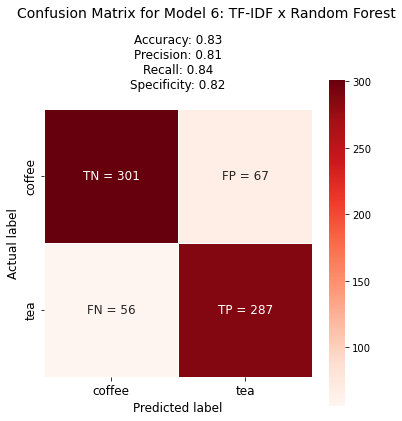

In [95]:
# plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm6, annot=np.array(modified_cm6),
            fmt="",
            annot_kws={"size": 12},
            linewidths=.5,
            square = True,
            cmap = 'Reds',
            xticklabels = ['coffee', 'tea'],
            yticklabels = ['coffee', 'tea'],
            );

plt.ylabel('Actual label', fontsize = 12);
plt.xlabel('Predicted label', fontsize = 12);
plt.title('Accuracy: {:.2f}'.format(score6)+'\n'
          +'Precision: {:.2f}'.format(prec6)+'\n'
          +'Recall: {:.2f}'.format(rec6)+'\n'
          + 'Specificity: {:.2f}'.format(spec6)+'\n', size = 12);
plt.tick_params(labelsize= 12)
plt.suptitle('Confusion Matrix for Model 6: TF-IDF x Random Forest', y = 1.05,fontsize=14)

### Model 6: Feature Importance

In [96]:
# pass best estimator model into a variable
gs6_model = gs6.best_estimator_

In [97]:
# set variables to access the model steps by name 
transformer6 = gs6_model.named_steps['tf']
estimator6 = gs6_model.named_steps['rf']

In [98]:
# create a dataframe to store feature name against the exponential of their coefficients
df6 = pd.DataFrame()
df6['feature'] = transformer6.get_feature_names()
df6['importance'] = estimator6.feature_importances_

In [99]:
# top 10 features
df6.sort_values(by=['importance'],ascending=False).head(20)

,feature,importance
824,espresso,0.029237
1510,machine,0.027794
224,bean,0.025512
1102,grinder,0.021813
1101,grind,0.019325
1098,green,0.013291
1426,leaf,0.012676
1105,ground,0.010767
2240,roast,0.009324
1523,make,0.009295


## Model Evaluation

**Accuracy** is the most important metric in our project, as both classes (tea and coffee) are equally important for us to classify correctly. There, our final evaluation is that based on the accuracy scores, CountVectorizer with Multinomial Naive Bayes model performed the best. 

It is noted that the accuracy scores for the models tested are marginally close. 

Depending on the company's management appetite, we can set a **threshold for false positive rate** to consider other models that can also be used. 

Text(0, 0.5, 'Model')

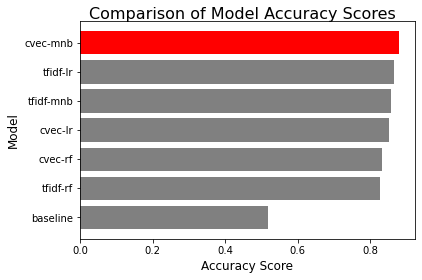

In [100]:
base_score = y_test.value_counts(normalize=True)[0]

models_accuracy = pd.DataFrame()
models_accuracy['score'] = [score1,score2,score3,score4,score5,score6,base_score]

models_accuracy['model'] = ['cvec-mnb','tfidf-mnb','tfidf-lr','cvec-lr','cvec-rf','tfidf-rf','baseline']
models_accuracy.set_index('model')

sorted_df = models_accuracy.sort_values('score',ascending=True)

plt.barh(sorted_df['model'],sorted_df['score'],color=['grey', 'grey', 'grey', 'grey', 'grey','grey','red'])
plt.suptitle('Comparison of Model Accuracy Scores', fontsize=16,y=0.93)
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)

> **Interpretation**
> 
> * All models performed much better than the baseline, as expected. 
> * Chart is arranged according on the descending value of accuracy scores. 
> * The train scores for random forest models are 1, but the test scores are significant lower (~0.2 delta), which implies overfitting. This could be because the dataset is noisy, and thus the random forest models are overfitting on them.
> * It is noted that if we are testing on truly unseen data, we will use the gridsearchCV best scores as the key metric to select the best model. 

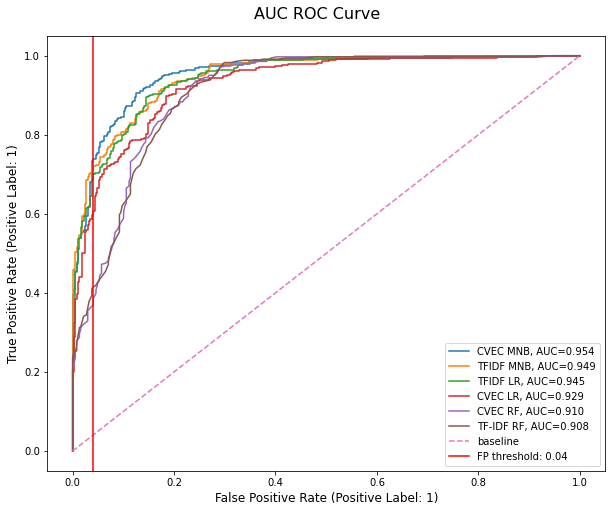

In [101]:
# overlapping ROC curves for all models

#set up plotting area
plt.figure(figsize=(10, 8)).clf()

# cvec mnb
y_pred1 = gs1_model.predict_proba(X_test)[:, 1]
fpr1, tpr1, _ = metrics.roc_curve(y_test, y_pred1)
auc1 = round(metrics.roc_auc_score(y_test, y_pred1), 4)
plt.plot(fpr1,tpr1,label="CVEC MNB, AUC="+str("{:.3f}".format(auc1)))

# tfidf mnb
y_pred2 = gs2_model.predict_proba(X_test)[:, 1]
fpr2, tpr2, _ = metrics.roc_curve(y_test, y_pred2)
auc2 = round(metrics.roc_auc_score(y_test, y_pred2), 4)
plt.plot(fpr2,tpr2,label="TFIDF MNB, AUC="+str("{:.3f}".format(auc2)))

# tfidf lr
y_pred3 = gs3_model.predict_proba(X_test)[:, 1]
fpr3, tpr3, _ = metrics.roc_curve(y_test, y_pred3)
auc3 = round(metrics.roc_auc_score(y_test, y_pred3), 4)
plt.plot(fpr3,tpr3,label="TFIDF LR, AUC="+str("{:.3f}".format(auc3)))

# cvec lr
y_pred4 = gs4_model.predict_proba(X_test)[:, 1]
fpr4, tpr4, _ = metrics.roc_curve(y_test, y_pred4)
auc4 = round(metrics.roc_auc_score(y_test, y_pred4), 4)
plt.plot(fpr4,tpr4,label="CVEC LR, AUC="+str("{:.3f}".format(auc4)))

# cvec rf
y_pred5 = gs5_model.predict_proba(X_test)[:, 1]
fpr5, tpr5, _ = metrics.roc_curve(y_test, y_pred5)
auc5 = round(metrics.roc_auc_score(y_test, y_pred5), 4)
plt.plot(fpr5,tpr5,label="CVEC RF, AUC="+str("{:.3f}".format(auc5)))

# tfidf rf
y_pred6 = gs6_model.predict_proba(X_test)[:, 1]
fpr6, tpr6, _ = metrics.roc_curve(y_test, y_pred6)
auc6 = round(metrics.roc_auc_score(y_test, y_pred6), 4)
plt.plot(fpr6,tpr6,label="TF-IDF RF, AUC="+str("{:.3f}".format(auc6)))

plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')

plt.suptitle('AUC ROC Curve', fontsize=16,y=0.93)
plt.xlabel('False Positive Rate (Positive Label: 1)', fontsize=12)
plt.ylabel('True Positive Rate (Positive Label: 1)', fontsize=12)
plt.axvline(x=0.04,c='r',label='FP threshold: 0.04')
plt.legend()

> **Interpretation**
> 
> * The higher the AUC, the better the model is at distinguishing between coffee and tea subreddits. 
> * In this project, the TF-IDF/MNB model performed marginally better than the CVEC/MNB model, with AUC delta of 0.01.
> * Depending on business considerations, we can set different thresholds for false positive rates which will provide different options for an appropriate model that can be used. 
>   * If we set FP threshold below 0.04 as illustrated with the red line, the CVEC/MNB model will perform better. 
>   * If we set a higher FP threshold, the TF-IDF/MNB model will clearly perform better.